This notebook is based on https://nextjournal.com/gkoehler/pytorch-mnist

In [1]:
!pip install torchvision torch tensorboard matplotlib --quiet

In [2]:
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

log_interval = 100

device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)

In [4]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
test_batch_size = 1000

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

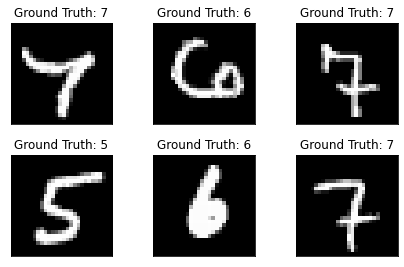

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
model = Net().to(device)

In [10]:
lr = 0.01
momentum = 0.5

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [11]:
def train(model, device, train_loader, optimizer, epoch, writer):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct = (predicted == target).sum().item()
        accuracy = correct / total

        if batch_idx  % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.2f} Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))

            niter = epoch*len(train_loader)+batch_idx
            writer.add_scalar('Train/Loss', loss.item(), niter)
            writer.add_scalar('Train/accuracy', accuracy, niter)

In [12]:
def test(model, device, test_loader, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    niter = epoch*len(test_loader)
    writer.add_scalar('Test/accuracy', float(correct) / len(test_loader.dataset), niter)
    print('\nTest accuracy={:.2f}\n'.format(float(correct) / len(test_loader.dataset)))

In [13]:
!rm -rf logs/*
writer = SummaryWriter('logs/')

In [14]:
epochs = 5

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, writer)
    test(model, device, test_loader, epoch, writer)

writer.close()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.33 Accuracy: 0.08
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.86 Accuracy: 0.34
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.15 Accuracy: 0.59
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.82 Accuracy: 0.73
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.05 Accuracy: 0.67
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.69 Accuracy: 0.78
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.64 Accuracy: 0.78
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.52 Accuracy: 0.81
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.46 Accuracy: 0.88
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.40 Accuracy: 0.89

Test accuracy=0.94

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.66 Accuracy: 0.83
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.35 Accuracy: 0.89
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.33 Accuracy: 0.89
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.33 Accuracy: 0.89
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.31 Accuracy: 0.89
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.30 Accuracy: 0.89
Train Epoch: 2 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


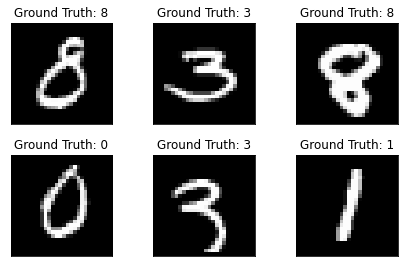

In [15]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output = model(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [16]:
torch.save(model.state_dict(),"mnist_cnn.pt")


In [17]:
#Works in juypter notebook but not in vscode
%load_ext tensorboard
%tensorboard --logdir logs